In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sheet = "/home/hduva/projects/ezfit/Ni reference spectra-optical constant-05172024.xlsx"

nk_Ni_all = pd.read_excel(sheet,sheet_name=1)
nk_Ni_all = nk_Ni_all[(nk_Ni_all["energy"] > 848) & (nk_Ni_all["energy"] < 862)].reset_index(drop=True)
nk_NiO_all = pd.read_excel(sheet,sheet_name=2)
nk_NiO_all = nk_NiO_all[(nk_NiO_all["energy"] > 848) & (nk_NiO_all["energy"] < 862)].reset_index(drop=True)
nk_NiOH2_alpha_all = pd.read_excel(sheet,sheet_name=4)
nk_NiOH2_alpha_all = nk_NiOH2_alpha_all[(nk_NiOH2_alpha_all["energy"] > 848) & (nk_NiOH2_alpha_all["energy"] < 862)].reset_index(drop=True)
nk_NiOoH_all = pd.read_excel(sheet,sheet_name=8)
nk_NiOoH_all = nk_NiOoH_all[(nk_NiOoH_all["energy"] > 848) & (nk_NiOoH_all["energy"] < 862)].reset_index(drop=True)

<Axes: xlabel='energy'>

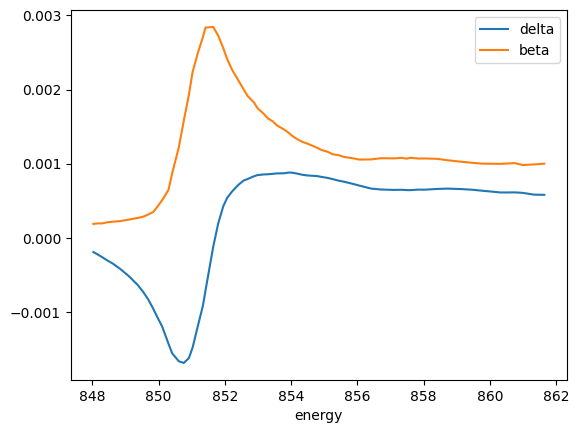

In [2]:
nk_Ni_all.plot(x = "energy")

<Axes: xlabel='energy'>

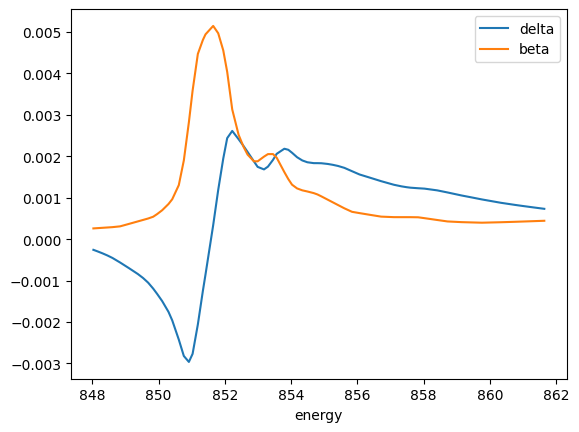

In [3]:
nk_NiO_all.plot(x = "energy")

<Axes: xlabel='energy'>

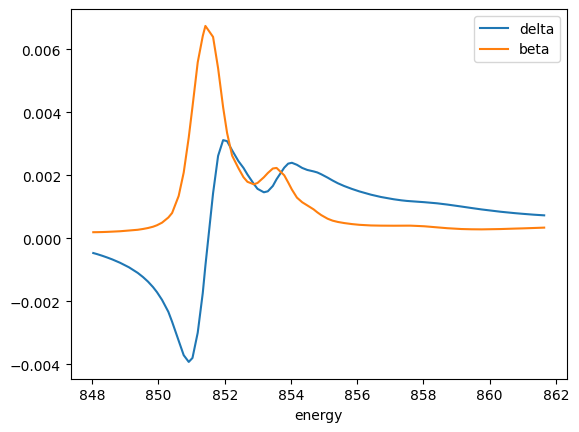

In [4]:
nk_NiOH2_alpha_all.plot(x = "energy")

<Axes: xlabel='energy'>

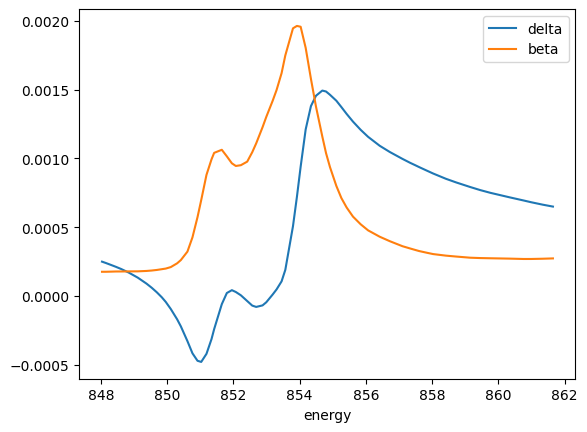

In [5]:
nk_NiOoH_all.plot(x = "energy")

<Axes: xlabel='energy', ylabel='beta'>

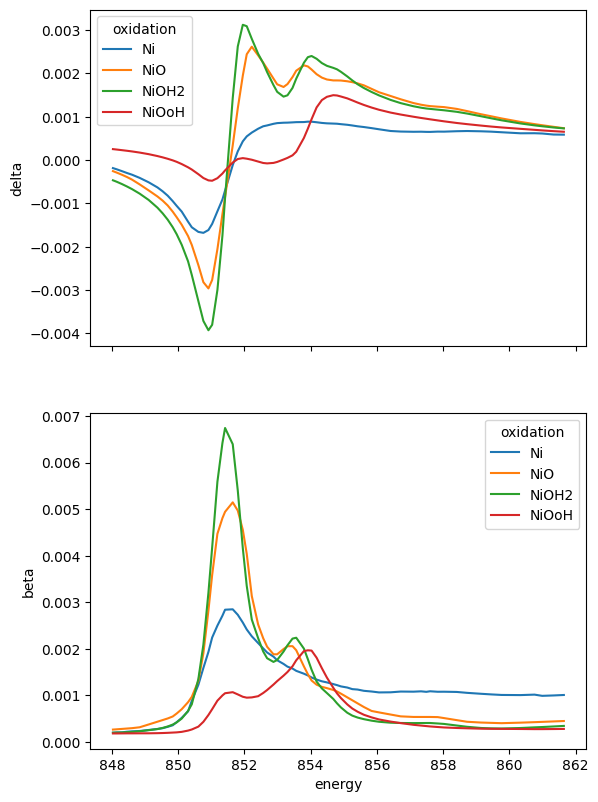

In [6]:
import seaborn as sns

# combine the dataframes into one, add index with oxidation
nk_Ni_all["oxidation"] = "Ni"
nk_NiO_all["oxidation"] = "NiO"
nk_NiOH2_alpha_all["oxidation"] = "NiOH2"
nk_NiOoH_all["oxidation"] = "NiOoH"

nk_all = pd.concat([nk_Ni_all,nk_NiO_all,nk_NiOH2_alpha_all,nk_NiOoH_all])
fig, ax = plt.subplots(nrows=2, figsize=(6.4, 9.6), sharex=True)
sns.lineplot(data=nk_all, x="energy", y="delta", hue="oxidation", ax=ax[0])
sns.lineplot(data=nk_all, x="energy", y="beta", hue="oxidation", ax=ax[1])

Text(0, 0.5, 'Intensity (a.u.)')

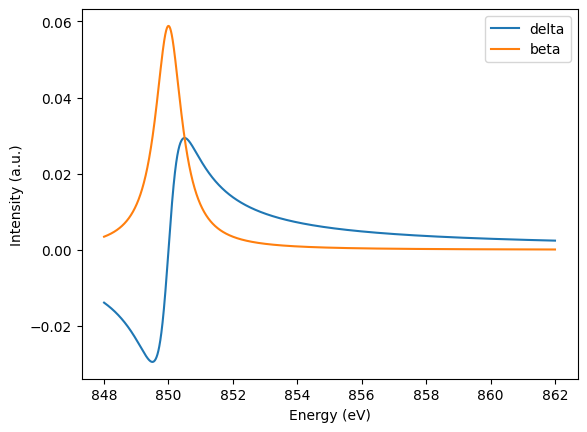

In [7]:
def dipole_peak(energy, res, gamma, strength):
  """Dipole oscillator peak line shape."""
  D = res**2 - energy**2 - 1j*gamma*energy
  return (1+.5*strength / D)

def delta_beta(energy, res, gamma, strength):
    n = dipole_peak(energy, res, gamma, strength)
    delta = 1 - n.real
    beta = n.imag
    return delta, beta

en = np.linspace(848, 862, 10000)
res = 850
n = delta_beta(en, res, 1, 100)

plt.plot(en, n[0], label="delta")
plt.plot(en, n[1], label="beta")
plt.legend()
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity (a.u.)")

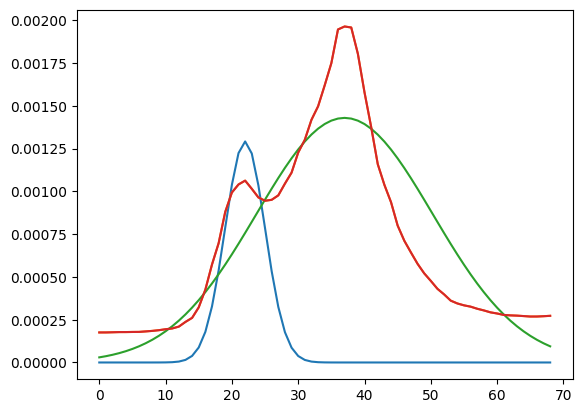

In [63]:
# run scipy peak finding on the nk_Ni_all dataset
from scipy.signal import find_peaks

def gaussian(x, x0, sigma, A):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def chi2(y, y_fit, sigma = 1):
    return np.sum((y - y_fit) ** 2 / sigma ** 2)

def generate_guesses(data: pd.DataFrame, column: str,  plot=False, ax=None):
    """Generate initial guesses for peak fitting based on a gaussian model."""
    peak_guesses, info = find_peaks(data[column], width=2, height=[data[column].values[0], data[column].max()])
    heights = info["peak_heights"]
    centers = data.index[peak_guesses].values
    widths = info["widths"]

    tol = .0001
    best_guesses = []
    for i, (c, h, w) in enumerate(zip(centers, heights, widths)):
      # ensure height is the peak height
      # gaussian jitter within the bounds and evaluate chi2 to find the best guess
      jitter = np.random.multivariate_normal([c, w, h], np.diag([tol, tol, tol]), 10000)
      # remove negative guesses of height, width, and center
      jitter = jitter[jitter[:, 0] > 0]
      jitter = jitter[jitter[:, 1] > 0]
      jitter = jitter[jitter[:, 2] > 0]
      # create a gaussian model for each jitter
      models = [gaussian(data.index.values, *j) for j in jitter]
      chi2s = [chi2(data[column], m) for m in models]
      # plt.plot(jitter[:, 0], chi2s, ".")
      best_guess = jitter[np.argmin(chi2s)]
      if plot:
        ax.plot(data.index.values, gaussian(data.index.values, *best_guess), label=f"guess {i}")
        ax.plot(data.index.values, data[column], label="data")
      best_guesses.append(best_guess)
    return best_guesses


fig, ax = plt.subplots()
guesses = generate_guesses(nk_NiOoH_all, "beta", plot=True, ax=ax)

multi_peak:
𝜒2: None
reduced 𝜒2: None
res1 : (value=851.417297363281 ± 0, bounds=(848.031982421875, 858.8925752645479))
res2 : (value=853.566162109375 ± 0, bounds=(849.7292304105061, 857.4030938082439))
res3 : (value=857.606079101562 ± 0, bounds=(855.4999428529272, 859.7122153501969))
gamma1 : (value=7.47527790126686 ± 0, bounds=(-inf, inf))
gamma2 : (value=3.8369316988688453 ± 0, bounds=(-inf, inf))
gamma3 : (value=2.10613624863484 ± 0, bounds=(-inf, inf))
strength1 : (value=11.48071783492205 ± 0, bounds=(0, 100))
strength2 : (value=3.812045216199089 ± 0, bounds=(0, 100))
strength3 : (value=0.6863166467297817 ± 0, bounds=(0, 100))


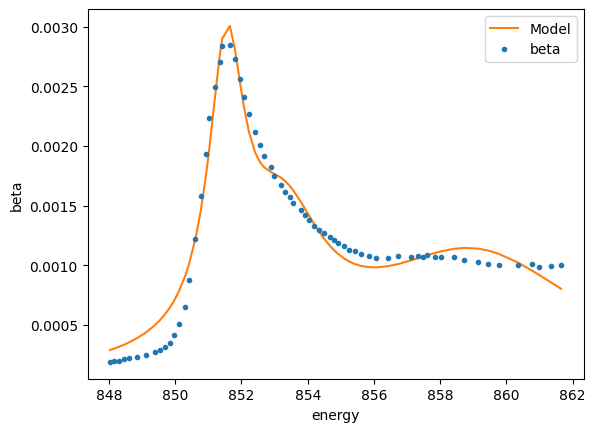

In [9]:
import ezfit

def multi_peak(energy, res1, res2, res3, gamma1, gamma2, gamma3,  strength1, strength2, strength3):
  """Multi-peak line shape."""
  n1 = dipole_peak(energy, res1, gamma1, strength1)
  n2 = dipole_peak(energy, res2, gamma2, strength2)
  n3 = dipole_peak(energy, res3, gamma3, strength3)
  n = n1 + n2 + n3
  beta = n.imag
  return beta


model, ax = nk_Ni_all.fit(multi_peak, "energy", "beta", res1=r[0], res2=r[1], res3=r[2],  gamma1=w[0], gamma2=w[1], gamma3=w[2], strength1=st[0], strength2=st[1], strength3=st[2])

multi_peak:
𝜒2: None
reduced 𝜒2: None
res1 : (value=851.417297363281 ± 0, bounds=(848.031982421875, 858.8925752645479))
res2 : (value=853.566162109375 ± 0, bounds=(849.7292304105061, 857.4030938082439))
res3 : (value=857.606079101562 ± 0, bounds=(855.4999428529272, 859.7122153501969))
gamma1 : (value=7.47527790126686 ± 0, bounds=(-inf, inf))
gamma2 : (value=3.8369316988688453 ± 0, bounds=(-inf, inf))
gamma3 : (value=2.10613624863484 ± 0, bounds=(-inf, inf))
strength1 : (value=11.48071783492205 ± 0, bounds=(0, 100))
strength2 : (value=3.812045216199089 ± 0, bounds=(0, 100))
strength3 : (value=0.6863166467297817 ± 0, bounds=(0, 100))


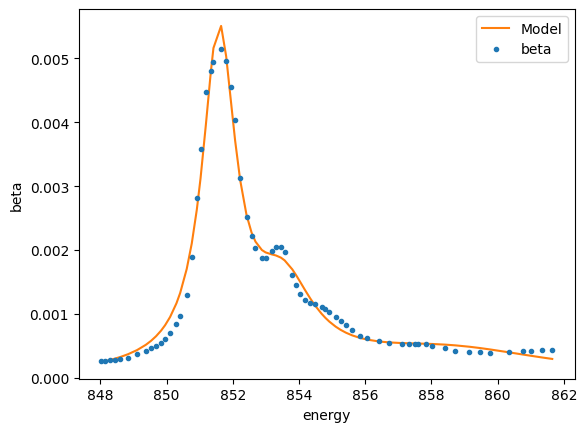

In [10]:
model_o, ax = nk_NiO_all.fit(multi_peak, "energy", "beta", res1=r[0], res2=r[1], res3=r[2],  gamma1=w[0], gamma2=w[1], gamma3=w[2], strength1=st[0], strength2=st[1], strength3=st[2])

multi_peak:
𝜒2: None
reduced 𝜒2: None
res1 : (value=851.417297363281 ± 0, bounds=(848.031982421875, 858.8925752645479))
res2 : (value=853.566162109375 ± 0, bounds=(849.7292304105061, 857.4030938082439))
res3 : (value=857.606079101562 ± 0, bounds=(855.4999428529272, 859.7122153501969))
gamma1 : (value=7.47527790126686 ± 0, bounds=(-inf, inf))
gamma2 : (value=3.8369316988688453 ± 0, bounds=(-inf, inf))
gamma3 : (value=2.10613624863484 ± 0, bounds=(-inf, inf))
strength1 : (value=11.48071783492205 ± 0, bounds=(0, 100))
strength2 : (value=3.812045216199089 ± 0, bounds=(0, 100))
strength3 : (value=0.6863166467297817 ± 0, bounds=(0, 100))


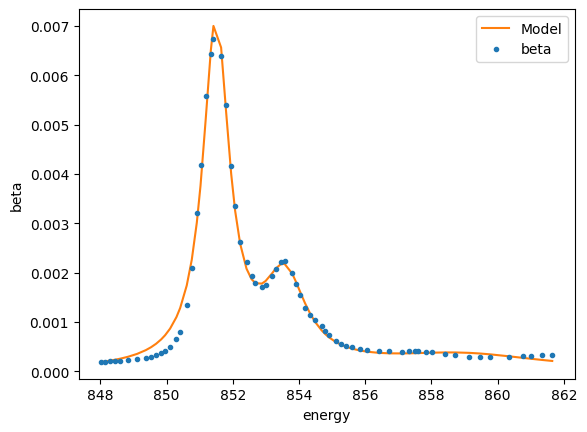

In [11]:
model_oh, ax = nk_NiOH2_alpha_all.fit(multi_peak, "energy", "beta", res1=r[0], res2=r[1], res3=r[2],  gamma1=w[0], gamma2=w[1], gamma3=w[2], strength1=st[0], strength2=st[1], strength3=st[2])

multi_peak:
𝜒2: None
reduced 𝜒2: None
res1 : (value=851.417297363281 ± 0, bounds=(848.031982421875, 858.8925752645479))
res2 : (value=853.566162109375 ± 0, bounds=(849.7292304105061, 857.4030938082439))
res3 : (value=857.606079101562 ± 0, bounds=(855.4999428529272, 859.7122153501969))
gamma1 : (value=7.47527790126686 ± 0, bounds=(-inf, inf))
gamma2 : (value=3.8369316988688453 ± 0, bounds=(-inf, inf))
gamma3 : (value=2.10613624863484 ± 0, bounds=(-inf, inf))
strength1 : (value=11.48071783492205 ± 0, bounds=(0, 100))
strength2 : (value=3.812045216199089 ± 0, bounds=(0, 100))
strength3 : (value=0.6863166467297817 ± 0, bounds=(0, 100))


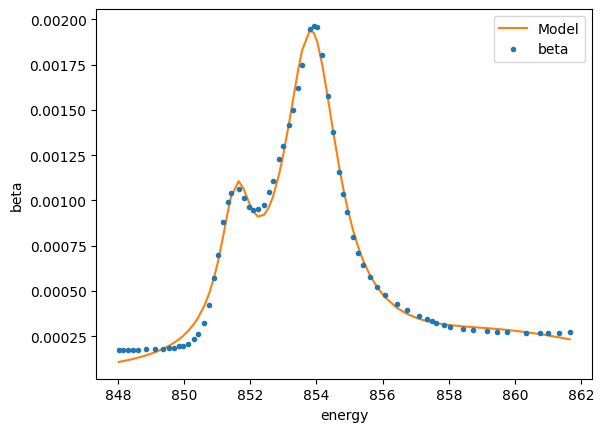

In [12]:
model_ooh, ax = nk_NiOoH_all.fit(multi_peak, "energy", "beta", res1=r[0], res2=r[1], res3=r[2],  gamma1=w[0], gamma2=w[1], gamma3=w[2], strength1=st[0], strength2=st[1], strength3=st[2])